# <b> Результат </b>

<p> 
    Модель реализована с использованием библиотеки scikit-learn. <br>
    <b>Достигнутая точность: 0.8189</b> <br>
    <b>F-score: 0.5602</b> <br>
    <b>Тип модели:</b> SVM (C = 3.8, тип ядра - poly5) <br>
    В наборе данных были удалены повторения.<br> 
    Пропущенные данные были заменены самым частым значением в соответствующей категории. <br>
    Данные преобразованы (Box-Cox transformation) и отмасштабированы (StandardScaler)<br>
    Применение PCA с автоматическим выбором конечной размерности не дало видного изменения точности. <br>
    Также и применение оверсэмплинга не дало улучшения результатов. 
    <h3> Вывод </h3><br>
    1. The model is biased <br>
    2. SVM показывает плохие результаты. Следует попробовать сеть. <br><br>
    Код приведен ниже.
</p>

Start
Final number of dimensions:  13
Start SVM 
 -------------------
Step  1
Step  2
Step  3
Step  4
Step  5
Step  6
Step  7
Step  8
Step  9
Step  10
Step  11
Step  12
Step  13
Step  14
Step  15
Step  16
Final accuracy:  0.8189
Final F-score:  0.5602


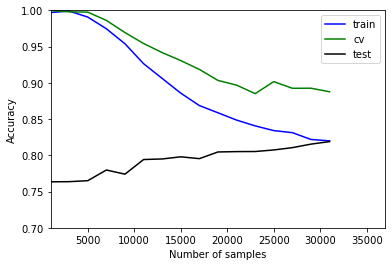

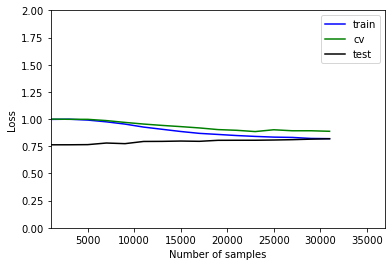

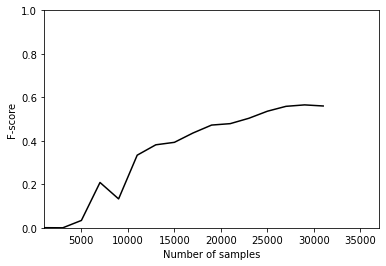

The end


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import hinge_loss
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from scipy import stats

# Первичная первичная обработка текста
def get_data(path, float_features_columns, categorial_features_columns):
    data = np.genfromtxt(path, 
                         delimiter=',', 
                         dtype='str', 
                         autostrip=1)

    data = np.char.lower(data)
    data, index = np.unique(data, 
                            axis=0, 
                            return_index=True)

    no_pt = data[:, data.shape[1] - 1] == '>n'
    pt = data[:, data.shape[1] - 1] == '>n.'
    y = (np.logical_or(no_pt, pt)).astype(np.int)
 
    float_features = data[:, float_features_columns].astype(np.float)
    categorial_features_strings = data[:, categorial_features_columns].astype(np.object) 
    return float_features, categorial_features_strings, y

print('Start')   
# Обозначаю столбцы с разными видами параметров
float_features_columns = np.array([0, 2, 4, 10, 11, 12]) 
categorial_features_columns = np.array([1, 3, 5, 6, 7, 8, 9, 13])
labels_float = np.array(["age", "final_weight", "education-num", "cap-gain", "cap-loss", 
                        "hours-per-week"], dtype=np.str)
labels_cat = np.array(["workclass", "education", "marital-status", "occupation", "relationship", "race", 
                      "sex", "native-country"], dtype=np.str)
labels = np.concatenate((labels_float, labels_cat))

float_features, categorial_features_strings, y = get_data('data.txt', 
                                                          float_features_columns, 
                                                          categorial_features_columns)

# Обработка missed values
natcoun_col_num = categorial_features_strings.shape[1]-1
categorial_features_strings[:, natcoun_col_num] = np.where(categorial_features_strings[:, natcoun_col_num]=='HERE', '?', categorial_features_strings[:, natcoun_col_num])
impute_most_freq = SimpleImputer(missing_values='?',
                                 strategy='most_frequent')  
categorial_features_strings = impute_most_freq.fit_transform(categorial_features_strings)

# Преобразование категорий в числа
encoder = OrdinalEncoder()
categorial_features = encoder.fit_transform(categorial_features_strings)

X = np.concatenate((float_features, categorial_features), 
                   axis=1)

'''# Over-samling
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)
'''

# Преобразование данных
pow_transform = PowerTransformer(standardize=False)
X = pow_transform.fit_transform(X)

stan_scaler = StandardScaler()
X = stan_scaler.fit_transform(X)

pca = PCA(n_components='mle')
X = pca.fit_transform(X)
print('Final number of dimensions: ', X.shape[1])


'''
# Визуализация распределений
num_features = X.shape[1]
n_bins =50
for i in range(num_features):
    skew = stats.skew(X[:, i])
    print("\n ---------{}---------- \n ".format(i), skew)  
    plt.hist(X[:, i], 
             bins=n_bins)
    plt.title("{}".format(labels[i]))
    plt.show()  
'''
# Загрузка тестового датасета
float_features_t, categorial_features_strings_t, y_t = get_data('test.txt', 
                                                                float_features_columns, 
                                                                categorial_features_columns)

natcoun_col_num = categorial_features_strings_t.shape[1]-1
categorial_features_strings_t[:, natcoun_col_num] = np.where(categorial_features_strings_t[:, natcoun_col_num]=='HERE', '?', categorial_features_strings_t[:, natcoun_col_num])
categorial_features_strings_t = impute_most_freq.transform(categorial_features_strings_t)
categorial_features_t = encoder.transform(categorial_features_strings_t)
X_t = np.concatenate((float_features_t, categorial_features_t), 
                   axis=1)
X_t = pow_transform.transform(X_t)
X_t = stan_scaler.transform(X_t)
X_t = pca.transform(X_t)

print('Start SVM \n -------------------')

'''
# Подбор гиперпараметров
parameters = {'kernel':['rbf', 'poly'], 'C':[1, 10], 'degree':[3, 4]}
svc = SVC()
clf = GridSearchCV(svc, parameters, refit=True)
clf.fit(X, y)
print(clf.best_params_, clf.best_score_)
'''

# Learning curves
plt.figure()
step = 2000
t = np.arange(1000, X.shape[0], step)
score_train, score_cv, score_t = np.array([]), np.array([]), np.array([])
loss_train, loss_cv, loss_t = np.array([]), np.array([]), np.array([])
f_score = np.array([])
step_count = 1

for j in range(1000, X.shape[0], step):
    clf = SVC(C=3.8, kernel='poly', degree=5)
    X_train, X_cv, y_train, y_cv = train_test_split(X[0:j, :], y[0:j], test_size=0.33, random_state=42)
    clf.fit(X_cv, y_cv)
    
    score_train = np.append(score_train, clf.score(X_train, y_train))
    score_cv = np.append(score_cv, clf.score(X_cv, y_cv))
    score_t = np.append(score_t, clf.score(X_t, y_t))
    
    loss_train = np.append(loss_train, hinge_loss(y_train, clf.predict(X_train)))
    loss_cv = np.append(loss_cv, hinge_loss(y_cv, clf.predict(X_cv)))
    loss_t = np.append(loss_t, hinge_loss(y_t, clf.predict(X_t)))
    
    f_score = np.append(f_score, f1_score(y_t, clf.predict(X_t)))
    print('Step ', step_count)
    step_count += 1

print('Final accuracy: ', '%.4f' %  score_t[score_t.shape[0] - 1])
print('Final F-score: ', '%.4f' %  f_score[f_score.shape[0] - 1])
plt.figure(1)
plt.xlabel('Number of samples')
plt.ylabel('Accuracy')
plt.axis([1000, 37000, 0.7, 1.0])
plt.plot(t, score_train, 'b-', label='train')
plt.plot(t, score_cv, 'g-', label='cv')
plt.plot(t, score_t, 'k-', label='test')
plt.legend()
plt.show()

plt.figure(2)
plt.xlabel('Number of samples')
plt.ylabel('Loss')
plt.axis([1000, 37000, 0, 2])
plt.plot(t, score_train, 'b-', label='train')
plt.plot(t, score_cv, 'g-', label='cv')
plt.plot(t, score_t, 'k-', label='test')
plt.legend()
plt.show()

plt.figure(3)
plt.xlabel('Number of samples')
plt.ylabel('F-score')
plt.axis([1000, 37000, 0, 1])
plt.plot(t, f_score, 'k-')
plt.show()
    
print('The end')